In [2]:
import os
import sys
from pathlib import Path

root_path = Path.cwd().parent.parent
print(root_path)
sys.path.append(str(root_path))

from src.settings import settings

/mnt/ssd2/steins/wenkai/project/doc-reading-agent-demo


In [3]:
from src.POC import *

In [ ]:
file_path = os.path.join(root_path, "demo_data", "test.pdf")

In [7]:
from pdf2image import convert_from_path
from PIL import Image
from io import BytesIO
from typing import List

def convert_to_jpeg(images: List[Image.Image]) -> List[Image.Image]:
    processed_images = []

    for img in images:
        # 步骤 A: 确保颜色模式是 RGB (防止 CMYK 导致保存 JPEG 失败)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        buffer = BytesIO()
        img.save(buffer, format='JPEG')
        buffer.seek(0)
        
        new_img = Image.open(buffer)
        processed_images.append(new_img)
    
    return processed_images

pdf_doc = convert_from_path(file_path, first_page=1)
images = convert_to_jpeg(pdf_doc)
print(f"Total pages converted to images: {len(images)}")
# for idx, img in enumerate(images):
#     img.save(f"page_{idx + 1}.jpeg", format='JPEG')

Total pages converted to images: 66


2026-01-08 19:57:18.313 | INFO     | __main__:__init__:30 - 通过HTTP请求访问JinaEmbedding服务: jina/jina-embeddings-v4-vllm-retrieval at http://localhost:9908/v1/embeddings 成功！
2026-01-08 19:57:18.315 | INFO     | __main__:_convert_to_base64:100 - 正在将 1 张图片转换为 Base64 编码, 以便发送到 Jina Embedding 服务...
2026-01-08 19:57:18.355 | INFO     | __main__:_convert_to_base64:109 - 图片转换为 Base64 编码完成！
2026-01-08 19:57:18.356 | INFO     | __main__:get_embedding:78 - payload构造完毕，前50字符: {'model': 'jina/jina-embeddings-v4-vllm-retrieval', 'messages': [{'role': 'user', 'content': [{'type': 'image_url', 'image_url': {'url': ''}}]}]}...

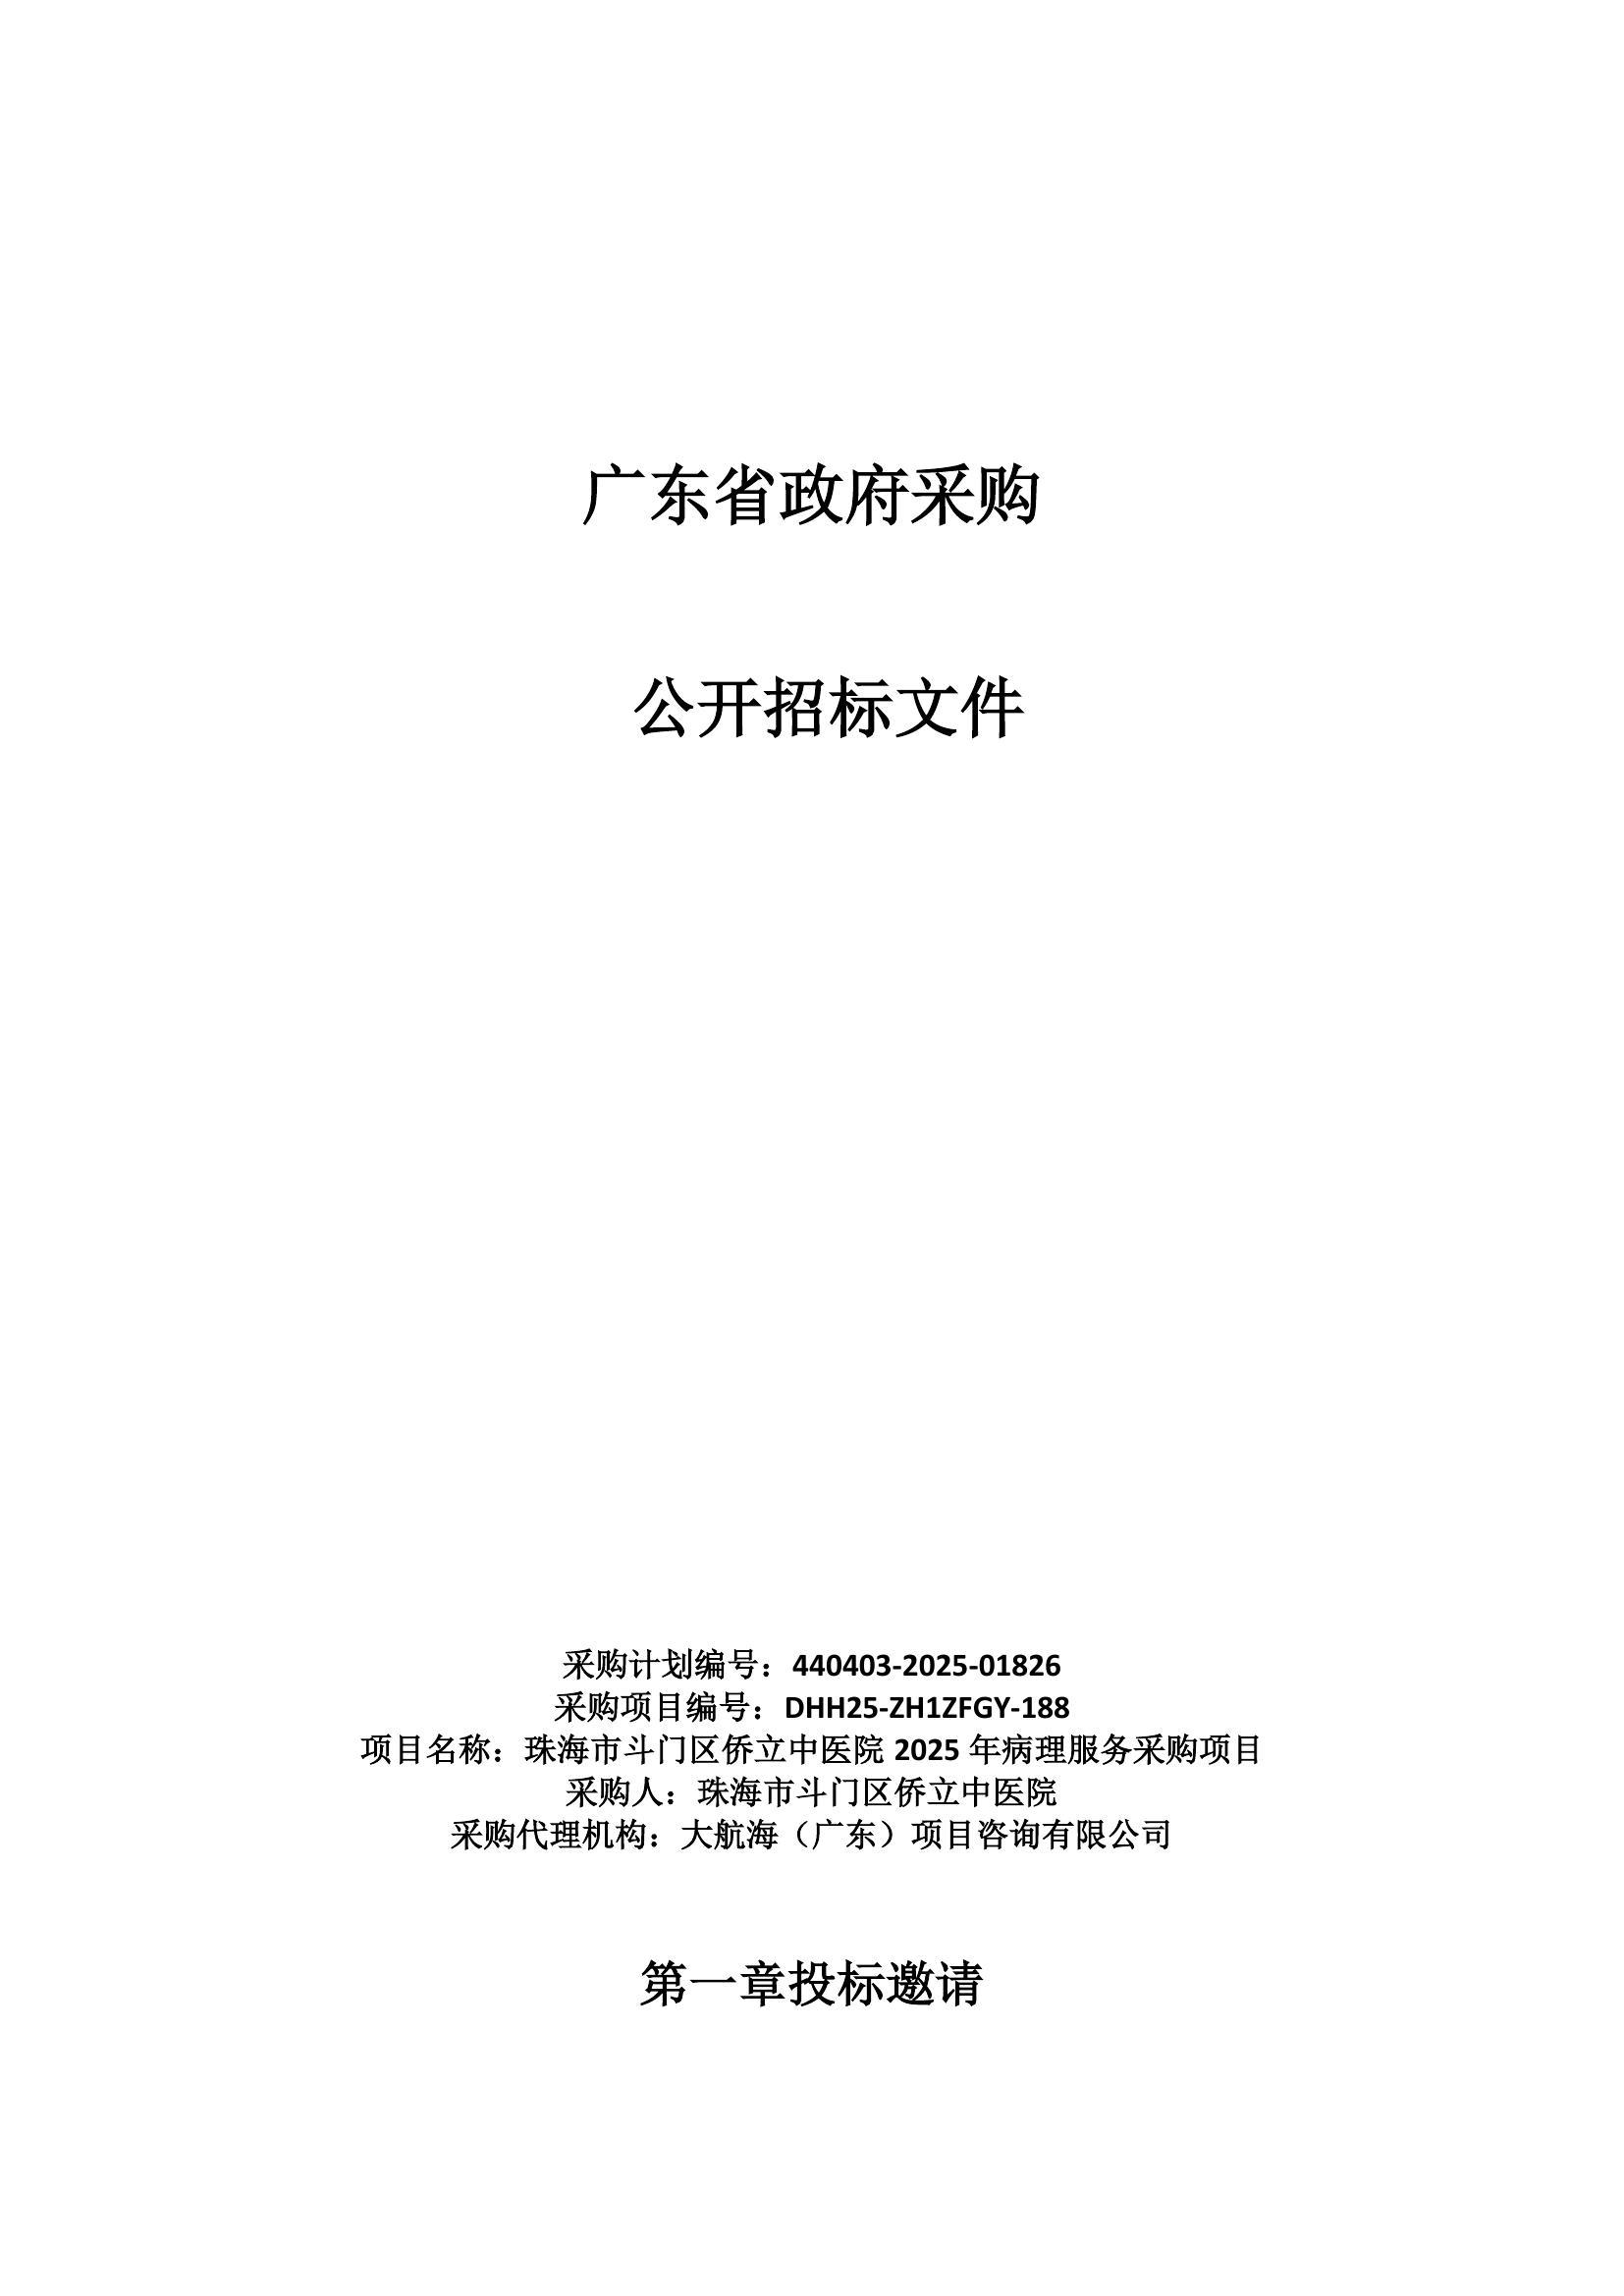

Embedding前20个维度: [0.004197034053504467, 0.00379011919721961, 0.008603338152170181, 0.0019590032752603292, 0.007370967883616686, 0.019866734743118286, -0.05294075608253479, -0.0035134172067046165, 0.0029623385053128004, -0.01084485650062561, -0.03398551046848297, -0.015699928626418114, 0.01657421514391899, -0.017811235040426254, -0.0592653751373291, 0.008528931066393852, 0.0011754019651561975, -0.01011938601732254, 0.03394830599427223, -0.010110084898769855]


In [6]:
import base64
import json
from typing import List, Dict, Any
from openai import OpenAI
import httpx
from httpx import AsyncClient, Timeout
import numpy as np
from loguru import logger

logger = logger.bind(name="JinaEmbedding客户端")

class JinaEmbeddingClient():
    def __init__(self,baseurl: str = "", api_key: str = "", embedding_name: str = "",):
        self.base_url = baseurl if baseurl else settings.JINA_EMBEDDING_BASE_URL
        self.api_key = api_key if api_key else settings.JINA_EMBEDDING_MODEL_API_KEY
        self.embedding_dim = settings.JINA_EMBEDDING_MODEL_DIMS
        self.embedding_name = embedding_name if embedding_name else settings.JINA_EMBEDDING_MODEL_NAME
        
        # self.base_url = settings.QWEN3_EMBEDDING_MODEL_BASE_URL
        # self.api_key = settings.QWEN3_EMBEDDING_MODEL_API_KEY
        # self.embedding_dim = None
        # self.embedding_name = settings.QWEN3_EMBEDDING_MODEL_NAME
        self.timeout = Timeout(60.0, connect=10.0)

        self.headers = {
            "Content-type": "application/json",
            "User-Agent": "wenkai_test"
        }
        
        logger.info(f"通过HTTP请求访问JinaEmbedding服务: {self.embedding_name} at {self.base_url} 成功！")
    
    async def get_embedding(self, text: str = "", *, image: Image.Image=None, is_base64=True) -> List[float]:
        """
        [异步] 获取多模态向量
        
        Args:
            text: 提示词文本
            image: PIL Image 对象 (可选)
        Returns:
            List[float]: 嵌入向量
        """

        content_block: List[Dict[str, Any]] = []

        if text:
            content_block.append(
                {
                    "type": "text",
                    "text":text 
                },
            )

        if image:
            image_http_url = ""#TODO：日后再添加，测试miniserve的静态文件服务器功能
            images_base64 = self._convert_to_base64(image)
            content_block.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{images_base64}"if is_base64 else f"{image_http_url}"
                    }
                }
            )
        
        if not content_block:
            logger.error(f"未提供文本或图片内容，无法获取嵌入向量！")
            raise ValueError("必须提供text或image内容至少一项！")
        
        payload = {
            "model": self.embedding_name,
            "messages": [
                {
                    "role": "user",
                    "content": content_block
                }
            ]
        }
        logger.info(f"payload构造完毕，前50字符: {str(payload)}...")

        async with AsyncClient(timeout=self.timeout) as client:
            try:
                response = await client.post(
                    url=self.base_url,
                    headers= self.headers,
                    json=payload
                )
                
                if response.status_code != 200:
                    raise ValueError(f"HTTP Error {response.status_code}: {response.text}")

                result = response.json()
                if "data" in result and len(result["data"])>0:
                    return result["data"][0]["embedding"]
                
            except httpx.RequestError as e:
                logger.warning(f"请求JinaEmbedding服务器时出现异常：{e}")
                raise 

    def _convert_to_base64(self, image: Image.Image) -> str:
        logger.info(f"正在将 1 张图片转换为 Base64 编码, 以便发送到 Jina Embedding 服务...")
        images_base64 = []
        buffer = BytesIO()
        image.save(buffer, format='JPEG')
        buffer.seek(0)
        img_bytes = buffer.read()
        img_base64 = base64.b64encode(img_bytes).decode('utf-8')
        images_base64.append(img_base64)

        logger.info(f"图片转换为 Base64 编码完成！")
        return images_base64[0]

    def _cal_cosine_similarity(self, vec1: List[float], vec2: List[float]) -> float:
        """用numpy计算两个向量的余弦相似度"""
        v1 = np.array(vec1)
        v2 = np.array(vec2)

        dot_product = np.dot(v1,v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        #防止除零
        if norm_v1 ==0 or norm_v2 ==0:
            return 0.0
        
        return dot_product / (norm_v1 * norm_v2)


        

jinaclient = JinaEmbeddingClient()
for img in images:
    embedding = await jinaclient.get_embedding(image=img)
    print(f"Embedding前20个维度: {embedding[:20]}")
while True:
    user_input = input("请输入您的问题（输入 'exit' 退出）：")
    if user_input.lower() == 'exit':
        break
    user_input_embedding = await jinaclient.get_embedding(text=user_input)
    similarity = jinaclient._cal_cosine_similarity(user_input_embedding, embedding)
    print("余弦相似度为:", similarity)
    print(f"与文档相似"if similarity >0.5 else "与文档不相似")
    

# 测试Qwen的embedding模型是否可用

In [27]:
from openai import OpenAI

model = OpenAI(
    base_url="http://localhost:9901/v1",
    api_key="EMPTY",
)

response = model.embeddings.create(input="你好",model="Qwen/Qwen3-Embedding-4B")
response

CreateEmbeddingResponse(data=[Embedding(embedding=[0.0014783223159611225, 0.043521810322999954, -0.021287841722369194, -0.01576877199113369, 0.0037253722548484802, 0.025387722998857498, 0.019474433735013008, -0.0024835816584527493, 0.11921191215515137, -0.05298307538032532, 0.002582136308774352, -0.018528306856751442, 0.03185291960835457, -0.040683429688215256, -0.013009237125515938, -0.06023670732975006, -0.029172228649258614, -0.022391656413674355, 0.02727997489273548, -0.0033508639317005873, -0.022391656413674355, 0.0018134088022634387, -0.01395536307245493, 0.03043372929096222, -0.08893587440252304, -0.030276041477918625, -0.03595279902219772, 0.05298307538032532, 0.016241835430264473, 0.0211301539093256, 0.03043372929096222, -0.04131418094038963, 0.016399523243308067, 0.024441596120595932, 0.0098554827272892, -0.033587485551834106, 0.03216829523444176, 0.013166924938559532, 0.011747734621167183, 0.034533608704805374, -0.028226101770997047, -0.028226101770997047, 0.0473063141107559

In [19]:
jinaclient = JinaEmbeddingClient()
embedding = await jinaclient.get_embedding(text="""这是一个测试文本广东省政府采购 
公开招标文件 
采购计划编号：440403-2025-01826 
采购项目编号：DHH25-ZH1ZFGY-188 
项目名称：珠海市斗门区侨立中医院2025年病理服务采购项目 
采购人：珠海市斗门区侨立中医院 
采购代理机构：大航海（广东）项目咨询有限公司 
第一章投标邀请 """)
print(f"Embedding前20个维度: {embedding[:20]}")
while True:
    user_input = input("请输入您的问题（输入 'exit' 退出）：")
    if user_input.lower() == 'exit':
        break
    user_input_embedding = await jinaclient.get_embedding(text=user_input)
    similarity = jinaclient._cal_cosine_similarity(user_input_embedding, embedding)
    print("余弦相似度为:", similarity)
    print(f"与文档相似"if similarity >0.5 else "与文档不相似")

2026-01-08 10:44:26.738 | INFO     | __main__:__init__:30 - 通过HTTP请求访问JinaEmbedding服务: jina/jina-embeddings-v4-vllm-retrieval at http://localhost:9908/v1/embeddings 成功！
2026-01-08 10:44:26.740 | INFO     | __main__:get_embedding:78 - payload构造完毕，前50字符: {'model': 'jina/jina-embeddings-v4-vllm-retrieval', 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': '这是一个测试文本广东省政府采购 \n公开招标文件 \n采购计划编号：440403-2025-01826 \n采购项目编号：DHH25-ZH1ZFGY-188 \n项目名称：珠海市斗门区侨立中医院2025年病理服务采购项目 \n采购人：珠海市斗门区侨立中医院 \n采购代理机构：大航海（广东）项目咨询有限公司 \n第一章投标邀请 '}]}]}...


Embedding前20个维度: [0.018903452903032303, -0.0022878132294863462, -0.0026976692024618387, -0.03616220876574516, 0.01030043140053749, -0.01578274928033352, -0.008133861236274242, -0.020252946764230728, 0.01981014385819435, 0.03498140349984169, -0.02521866001188755, 0.028086334466934204, 0.009056366980075836, 0.006842353846877813, -0.0300894882529974, -0.0015050015645101666, 0.017532873898744583, -0.03852382302284241, 0.019662542268633842, -0.027727875858545303]


2026-01-08 10:44:28.104 | INFO     | __main__:get_embedding:78 - payload构造完毕，前50字符: {'model': 'jina/jina-embeddings-v4-vllm-retrieval', 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': '### **第一页内容总结：**  - **文件类型**：广东省政府采购公开招标文件。 - **采购计划编号**：440403-2025-01826   - **采购项目编号**：DHH25-ZH1ZFGY-188   - **项目名称**：珠海市斗门区侨立中医院 2025 年病理服务采购项目   - **采购人**：珠海市斗门区侨立中医院   - **采购代理机构**：大航海(广东)项目咨询有限公司   - **章节信息**：本文件为《第一章 投标邀请》的起始页，标志着招标程序的正式开启。'}]}]}...


余弦相似度为: 0.7734075732651663
与文档相似


2026-01-08 10:44:50.540 | INFO     | __main__:get_embedding:78 - payload构造完毕，前50字符: {'model': 'jina/jina-embeddings-v4-vllm-retrieval', 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': '我随便说一个话，我是张文凯，我是广东省省长'}]}]}...


余弦相似度为: 0.19874629356852133
与文档不相似


# 保存image到本地

In [ ]:
from PIL import Image
import os

def save_image_as_jpeg(img: Image.Image, output_folder: str, filename: str):
    # 1. 确保目标文件夹存在 (如果不存在会自动创建)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 2. 拼接完整路径
    save_path = os.path.join(output_folder, filename)

    # 3. 【关键】处理透明度问题
    # 如果图片是 RGBA (带透明) 或 P (调色板) 模式，JPEG 不支持，需转为 RGB
    if img.mode in ("RGBA", "P"):
        img = img.convert("RGB")

    # 4. 保存文件
    # quality 参数可选 (1-95)，默认约 75，95 为最高质量
    img.save(save_path, "JPEG", quality=95)
    print(f"图片已保存到: {save_path}")

# --- 使用示例 ---
# 假设你有一个 Image 对象叫 my_img
for i,img in enumerate(images):
    save_image_as_jpeg(img, "../../demo_data_images", f"test_{i+1}.jpeg")

图片已保存到: ../../示例数据_images/test_1.jpeg
图片已保存到: ../../示例数据_images/test_2.jpeg
图片已保存到: ../../示例数据_images/test_3.jpeg
图片已保存到: ../../示例数据_images/test_4.jpeg
图片已保存到: ../../示例数据_images/test_5.jpeg
图片已保存到: ../../示例数据_images/test_6.jpeg
图片已保存到: ../../示例数据_images/test_7.jpeg
图片已保存到: ../../示例数据_images/test_8.jpeg
图片已保存到: ../../示例数据_images/test_9.jpeg
图片已保存到: ../../示例数据_images/test_10.jpeg
图片已保存到: ../../示例数据_images/test_11.jpeg
图片已保存到: ../../示例数据_images/test_12.jpeg
图片已保存到: ../../示例数据_images/test_13.jpeg
图片已保存到: ../../示例数据_images/test_14.jpeg
图片已保存到: ../../示例数据_images/test_15.jpeg
图片已保存到: ../../示例数据_images/test_16.jpeg
图片已保存到: ../../示例数据_images/test_17.jpeg
图片已保存到: ../../示例数据_images/test_18.jpeg
图片已保存到: ../../示例数据_images/test_19.jpeg
图片已保存到: ../../示例数据_images/test_20.jpeg
图片已保存到: ../../示例数据_images/test_21.jpeg
图片已保存到: ../../示例数据_images/test_22.jpeg
图片已保存到: ../../示例数据_images/test_23.jpeg
图片已保存到: ../../示例数据_images/test_24.jpeg
图片已保存到: ../../示例数据_images/test_25.jpeg
图片已保存到: ../../示例数据_images/test_26.